# Install packages

In [1]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 2.6 MB 3.9 MB/s 
     |████████████████████████████████| 636 kB 73.6 MB/s 
     |████████████████████████████████| 895 kB 74.2 MB/s 
     |████████████████████████████████| 3.3 MB 23.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 264 kB 4.3 MB/s 
     |████████████████████████████████| 243 kB 60.5 MB/s 
     |████████████████████████████████| 118 kB 62.4 MB/s 


In [95]:
#import packages

import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, precision_score, recall_score, f1_score
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig, DistilBertForSequenceClassification, Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer, DistilBertTokenizerFast
import seaborn as sns
import re
import os
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pickle as pkl
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Embedding, TimeDistributed, Dropout, LSTM
from keras.models import Sequential, load_model
from datasets import load_metric
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load helper functions

In [3]:
#function to create fakenewsdataset class to be input into transfomer for testing

def transformer(model, tokenizer, test_texts, test_labels):

    test_encodings = tokenizer(test_texts, truncation=True, padding=True)

    class fake_news_dataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
           item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
           item['labels'] = torch.tensor(self.labels[idx])
           return item

        def __len__(self):
            return len(self.labels)

    test_dataset = fake_news_dataset(test_encodings, test_labels)

    return test_dataset

In [4]:
#function to create training, validation and testing datasets to be used for transformer training

def transformer_train_val_test(model, tokenizer, text, labels):

    train_texts, test_texts, train_labels, test_labels = train_test_split(text, labels, test_size=.2)
    train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

    train_encodings = tokenizer(train_texts, truncation=True, padding=True)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True)
    test_encodings = tokenizer(test_texts, truncation=True, padding=True)

    class fake_news_dataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
           item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
           item['labels'] = torch.tensor(self.labels[idx])
           return item


        def __len__(self):
            return len(self.labels)

 
    train_dataset = fake_news_dataset(train_encodings, train_labels)
    val_dataset = fake_news_dataset(val_encodings, val_labels)
    test_dataset = fake_news_dataset(test_encodings, test_labels)

    return train_dataset, val_dataset, test_dataset

In [5]:
#function to turn x and y variables into lists, ready for processing into fakenewsdataset objects

def transformer_preprocessing(x, y):
    x = x.tolist()
    y = y.tolist()
    return x,y

In [6]:
#function to return evaluation metrics reported

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average= 'macro')
    return {
        'f1': f1,
        
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy_score(labels, predictions)
    }

In [7]:
#function to print all evaluation metrics for ML and DL models

def print_metrics(model, y, predictions):
  print(model,  'metrics: ', 'accuracy: ', accuracy_score(y, predictions), 'precision: ', 
        precision_score(y, predictions, average = 'macro'), 'recall: ', recall_score(y, predictions, average = 'macro'), 'f1 score: ', f1_score(y, predictions, average = 'macro'))

In [8]:
def opinion_filtering(model_path, tokenizer_path, dataset):
  model = AutoModelForSequenceClassification.from_pretrained(model_path)
  tokenizer = AutoTokenizer.from_pretrained(model_path)

  x,y = transformer_preprocessing(dataset['clean_words'], dataset['label'])
  all_data = transformer(model, tokenizer, x, y)

  trainer = Trainer(model = model)
  preds = trainer.predict(all_data)
  preds = preds.predictions.argmax(-1)
  dataset['fact_opinion'] = preds
  step_1_df = dataset[dataset['fact_opinion'] == 0]

  return step_1_df

In [35]:
#set filepath locations
step_1_isot_df_filepath = '/content/drive/MyDrive/Dissertation/deBERTa/ISOT/step_1_df_clean_words.pkl'
step_1_cc_df_filepath = '/content/drive/MyDrive/Dissertation/deBERTa/Step_1_df_clean_words.pkl'
isot_df_filepath = '/content/drive/MyDrive/Dissertation/ISOT_clean_words.pkl'
cc_data_filepath = '/content/drive/MyDrive/Dataset/Combined_Corpus/Train/'  
cc_df_filepath = '/content/drive/MyDrive/Dissertation/CC_clean_words.pkl'
fact_opinion_model_filepath = '/content/drive/MyDrive/Dissertation/DistilBert/Step_1/50_epochs'

# ISOT dataset

In [19]:
def clean_fake(text):
    cleaned_text_1 = re.sub('".*?"', '', text)
    cleaned_text = re.sub(r'\.(?=[^ \W\d])', '. ', cleaned_text_1)
    return cleaned_text

def clean(text):
    # removing all the characters other than alphabets
    cleaned_text_1= re.sub("[^a-zA-Z]", " ", text)
    cleaned_text_2 = re.sub(r'\W+', ' ', cleaned_text_1)
    # converting text to lower case
    cleaned_text = re.sub("\d+", " ", cleaned_text_2)
    #all lowercase
    cleaned_text= cleaned_text.lower()
    return cleaned_text


def load_big_dataset():
  fake_news = pd.read_csv('/content/drive/MyDrive/Fake.csv')
  real_news = pd.read_csv('/content/drive/MyDrive/True.csv')

  #removing publisher name before '-' at start of all real articles
  real_news['text'] = real_news['text'].apply(lambda x : re.sub(r'^.*?-', '-', x))

  #run cleaning on fake news to add spaces after each full stop
  fake_news["text"]= fake_news['text'].apply(lambda x : clean_fake(x) )

  #remove last sentence from fake news articles
  for i in range(0, len(fake_news)):
    text = fake_news['text'][i]
    sent_text = nltk.sent_tokenize(text)
    sent_removed = sent_text[0:-1]
    fake_news['text'][i] = " ".join(sent_removed)

  #add binary labels
  fake_news['label'] = 1
  real_news['label'] = 0

  #join real and fake news
  all_news = pd.concat([real_news, fake_news])

  #clean text
  all_news["clean_text"]= all_news["text"].apply(lambda x : clean(x) )
  all_news['clean_text'] = all_news['clean_text'].apply(lambda x : x.replace(' s ', ' '))

  #reset index
  all_news = all_news.reset_index(drop = True)

  return all_news

def stop_words_fun(col):
  text = col 
  string = str(text)
  text_tokens = word_tokenize(string)
  tokens_without_sw = [word for word in text_tokens if not word in stop]
  joined = " ".join(tokens_without_sw)
  return joined


In [20]:
#load data and shuffle rows
isot_df = load_big_dataset()
isot_df = all_news.sample(frac=1).reset_index(drop=True)

In [21]:
#remove stopwords
stop = stopwords.words('english')
stop = set(stop)

def remove_stop_words(col):
  text = str(col)
  sent_text = nltk.sent_tokenize(text)
  return sent_text

isot_df['stop_words'] = isot_df['clean_text'].apply(lambda x : remove_stop_words(x))

isot_df['clean_words'] = isot_df['stop_words'].apply(lambda x: stop_words_fun(x))

isot_df = isot_df.drop_duplicates(subset = 'clean_words')

In [10]:
#save preprocessed dataframe
#pkl.dump(dfs, open(isot_df_filepath, 'wb'))
#open saved dataframe
isot_df = pd.read_pickle(isot_df_filepath)

In [ ]:
isot_df['label'].value_counts()

0    20920
1    17080
Name: label, dtype: int64

# Combined corpus

In [13]:
def clean(text):
    # removing all the characters other than alphabets
    cleaned_text_1= re.sub("[^a-zA-Z]", " ", text)
    cleaned_text_2 = re.sub(r'\W+', ' ', cleaned_text_1)
    # converting text to lower case
    cleaned_text = re.sub("\d+", " ", cleaned_text_2)
    
    cleaned_text= cleaned_text.lower()

    return cleaned_text

from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop = set(stop)

def stop_words_fun(col):
  text = col 
  string = str(text)
  text_tokens = word_tokenize(string)
  tokens_without_sw = [word for word in text_tokens if not word in stop]
  joined = " ".join(tokens_without_sw)
  return joined


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
import os
#read in combined corpus from multiple csv files
path = cc_data_filepath
trains = os.listdir(path)

df_total = pd.DataFrame()

#combine all combined corpus files into one dataframe
for train in trains:
    csv = pd.read_csv(path + train, engine = 'python', error_bad_lines=False)
    df_total = df_total.append(csv)

Skipping line 3397: unexpected end of data
Skipping line 163: Expected 3 fields in line 163, saw 6
Skipping line 164: Expected 3 fields in line 164, saw 6
Skipping line 165: Expected 3 fields in line 165, saw 4
Skipping line 169: Expected 3 fields in line 169, saw 5
Skipping line 171: Expected 3 fields in line 171, saw 8
Skipping line 2591: unexpected end of data
Skipping line 32: ',' expected after '"'
Skipping line 2737: unexpected end of data
Skipping line 3850: unexpected end of data
Skipping line 3469: unexpected end of data
Skipping line 173: ',' expected after '"'
Skipping line 159: Expected 5 fields in line 159, saw 6
Skipping line 3469: unexpected end of data
Skipping line 2588: unexpected end of data
Skipping line 330: Expected 2 fields in line 330, saw 3
Skipping line 332: Expected 2 fields in line 332, saw 4
Skipping line 333: Expected 2 fields in line 333, saw 7
Skipping line 335: Expected 2 fields in line 335, saw 5
Skipping line 336: Expected 2 fields in line 336, saw 4


In [15]:
df_total = df_total.reset_index(drop = True)
#drop rows where there are no labels
cc_df = df_total[(df_total['Label'] == 0) | (df_total['Label'] == 1) | (df_total['Label'] == "0") | (df_total['Label'] == "1")]
cc_df['Label'] = pd.to_numeric(cc_df['Label'])

#apply cleaning function
cc_df["clean_words"]= cc_df["Statement"].apply(lambda x : clean(x) )
#remove 's' from corpus
cc_df['clean_words'] = cc_df['clean_words'].apply(lambda x : x.replace(' s ', ' '))
#remove stop words, takes a little while to run
cc_df["clean_words"]= cc_df["clean_words"].apply(lambda x : stop_words_fun(x) )
#switch labels so that false articles are 1
cc_df['label'] = np.where(cc_df['Label'] == 1.0, 0,1) 

cc_df = cc_df.dropna()
cc_df = cc_df.drop_duplicates()
cc_df = cc_df.reset_index(drop = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
cc_df['Label'].value_counts()

1.0    30847
0.0    29501
Name: Label, dtype: int64

In [32]:
#save cleaned dataset
#pkl.dump(dfs, open(cc_df_filepath, 'wb'))
#open saved dataframe
cc_df = pd.read_pickle(cc_df_filepath)

Generate word clouds for each dataset

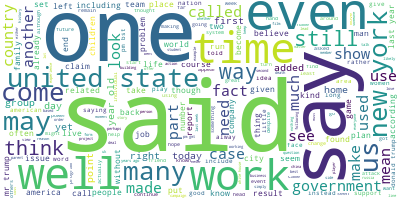

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(review for review in cc_df.clean_words)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(text)
# Visualize the word cloud
wordcloud.to_image()

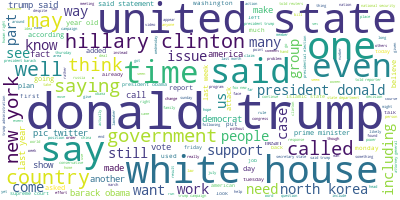

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(review for review in isot_df.clean_words)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(text)
# Visualize the word cloud
wordcloud.to_image()

# Baseline ML models

In [37]:
def testing_ml_baseline(training_data):
  #split data into training and testing
  train_data, test_data, train_labels, test_labels = train_test_split(training_data['clean_words'], training_data['label'], test_size = 0.2, random_state = 42)
  #load and fit tfidf vectoriser to training data
  vectorizer = TfidfVectorizer()
  x = vectorizer.fit_transform(train_data)
  y = train_labels

  #fit ML baseline models
  logreg = LogisticRegression(random_state=42)
  logreg.fit(x,y)

  nb = MultinomialNB()
  nb.fit(x,y)

  rd = RandomForestClassifier(verbose=1, random_state=42)
  rd.fit(x,y)

  #vectorise test data
  test_sequences = vectorizer.transform(test_data)

  #predict using trained models
  y_pred_rd = rd.predict(test_sequences)
  y_pred = logreg.predict(test_sequences)
  y_pred_nb = nb.predict(test_sequences)

  #print metrics
  print_metrics('Random forest', test_labels, y_pred_rd)
  print_metrics('Logistic regression', test_labels, y_pred)
  print_metrics('Naive Bayes', test_labels, y_pred_nb)

  return logreg, nb, rd

In [39]:
#logreg_isot, nb_isot, rd_isot = testing_ml_baseline(isot_df)
logreg_cc, nb_cc, rd_cc = testing_ml_baseline(dfs) # takes around 4 mins to run

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Random forest metrics:  accuracy:  0.927754763877382 precision:  0.92832732532432 recall:  0.9272475104371236 f1 score:  0.9276066248222397
Logistic regression metrics:  accuracy:  0.9625517812758906 precision:  0.9624364428849657 recall:  0.9626448763771418 f1 score:  0.9625241064342744
Naive Bayes metrics:  accuracy:  0.9075393537696769 precision:  0.914660746411621 recall:  0.9055682174967261 f1 score:  0.9067621391706165


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished


In [50]:
#test out of distribution generalisation with baseline models

def ml_generalisation(training_data, test_df, logreg, nb, rd):
  train_data, test_data, train_labels, test_labels = train_test_split(training_data['clean_words'], training_data['label'], test_size = 0.2, random_state = 42)

  vectorizer = TfidfVectorizer()
  x = vectorizer.fit_transform(train_data)
  y = train_labels
  test = vectorizer.transform(test_df['clean_words'])
  test_labels = test_df['label']

  if rd == True:
    rd = RandomForestClassifier(random_state = 42)
    rd.fit(x,y)
    
  if nb == True:
    nb = MultinomialNB()
    nb.fit(x,y)

  if logreg == True:
    logreg = LogisticRegression(random_state = 42)
    logreg.fit(x,y)

  test_sequences = vectorizer.transform(test_df['clean_words'])
  test_labels = test_df['label']

  #predict using combined corpus data with models trained on ISOT data
  y_pred_rd = rd.predict(test_sequences)
  y_pred = logreg.predict(test_sequences)
  y_pred_nb = nb.predict(test_sequences)

  #print metrics
  print_metrics('Random forest', test_labels, y_pred_rd)
  print_metrics('Logistic regression', test_labels, y_pred)
  print_metrics('Naive Bayes', test_labels, y_pred_nb)


In [51]:
#get generalisation results
ml_generalisation(isot_df, cc_df, True, True, True)
#ml_generalisation(cc_df, True, True, True)

Random forest metrics:  accuracy:  0.6505435142838205 precision:  0.6908417743704929 recall:  0.6554299305021929 f1 score:  0.6352968924329137
Logistic regression metrics:  accuracy:  0.6589944985749321 precision:  0.7495073204124441 recall:  0.6655491002414924 f1 score:  0.6302025726701967
Naive Bayes metrics:  accuracy:  0.6349837608537151 precision:  0.6506342590412106 recall:  0.6382579869656044 f1 score:  0.6284544663840792


In [53]:
step_1_isot_df = pd.read_pickle(step_1_isot_df_filepath)
step_1_cc_df = pd.read_pickle(step_1_cc_df_filepath)

In [59]:
#testing OOD generalisation with filtered training data, input step_1_dfs
def ml_step_1_generalisation(step_1_training_data, test_df, rd, nb, logreg):
  train_data, test_data, train_labels, test_labels = train_test_split(step_1_training_data['clean_words'], step_1_training_data['label'], test_size = 0.2, random_state = 42)

  vectorizer = TfidfVectorizer()
  x = vectorizer.fit_transform(train_data)
  y = train_labels
  test = vectorizer.transform(test_df['clean_words'])
  test_labels = test_df['label']

  if rd == True:
    rd = RandomForestClassifier(random_state = 42)
    rd.fit(x,y)
    
  if nb == True:
    nb = MultinomialNB()
    nb.fit(x,y)

  if logreg == True:
    logreg = LogisticRegression(random_state = 42)
    logreg.fit(x,y)

  rd_preds = rd.predict(test)
  print_metrics('Random Forest', test_df['label'], rd_preds)
    
  nb_preds = nb.predict(test)
  print_metrics('Naive Bayes', test_df, nb_preds)

  logreg_preds = logreg.predict(test)
  print_metrics('Logistic Regression', test_df, logreg_preds)

# LSTM baseline

In [61]:
model_path_ISOT = "/content/drive/MyDrive/LSTM_isot_step_1_macro_test.hdf5"
model_path_CC = "/content/drive/MyDrive/LSTM_isot_step_1_macro_test.hdf5"

In [86]:
def process_lstm(training_data):
  #split training and testing data
  train_data, test_data, train_labels, test_labels = train_test_split(training_data['clean_words'], training_data['label'], test_size = 0.2, random_state = 42)
  text = train_data

  #tokenize words
  ml_tokenizer = Tokenizer()
  ml_tokenizer.fit_on_texts(text)
  sequences = ml_tokenizer.texts_to_sequences(train_data)
  sequences = pad_sequences(sequences)
  vocab_size = len(ml_tokenizer.word_index) + 1

  y = train_labels
  x = sequences

  return ml_tokenizer, x,y, test_data, test_labels

In [87]:
tokenizer_isot, x_isot, y_isot, test_data, test_labels = process_lstm(isot_df)
#tokenizer_cc, x_cc, y_cc, test_data, test_labels = process_lstm(cc_df)

lstm_sequences_isot = np.asarray(x_isot)
seq_length_isot = x_isot.shape[1]
n_classes = 1
vocab_size_isot = len(tokenizer_isot.word_index) + 1

#lstm_sequences_cc = np.asarray(x_cc)
#seq_length_cc = x_cc.shape[1]
#n_classes = 1
#vocab_size_cc = len(tokenizer_cc.word_index) + 1

In [74]:
#Build model
def create_model(vocab_size, seq_length):
  model = Sequential()
  model.add(Embedding(vocab_size,40,input_length = seq_length))  
  model.add(Dropout(0.3))
  model.add(LSTM(100))  
  model.add(Dropout(0.3))
  model.add(Dense(64,activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1,activation='sigmoid'))  
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', 'precision', 'recall', 'f1'])
  print(model.summary())
  return model

lstm = create_model(vocab_size_isot, seq_length_isot)

#Compile model
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4976, 40)          4085440   
_________________________________________________________________
dropout (Dropout)            (None, 4976, 40)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [81]:
x = x_isot
y = y_isot

#x = x_cc
#y = y_cc

------------------------------------
Training model...
Epoch 1/3
855/855 [==============================] - 168s 196ms/step - loss: 0.0911 - accuracy: 0.9741 - val_loss: 0.1257 - val_accuracy: 0.9681

Epoch 00001: saving model to /content/drive/MyDrive/LSTM_isot_step_1_macro_test.hdf5
Epoch 2/3
855/855 [==============================] - 172s 201ms/step - loss: 0.5412 - accuracy: 0.6996 - val_loss: 0.3515 - val_accuracy: 0.8658

Epoch 00002: saving model to /content/drive/MyDrive/LSTM_isot_step_1_macro_test.hdf5
Epoch 3/3
855/855 [==============================] - 172s 202ms/step - loss: 0.3121 - accuracy: 0.8681 - val_loss: 0.4179 - val_accuracy: 0.8046

Epoch 00003: saving model to /content/drive/MyDrive/LSTM_isot_step_1_macro_test.hdf5


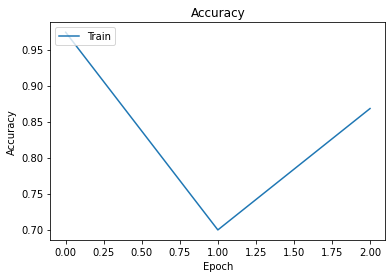

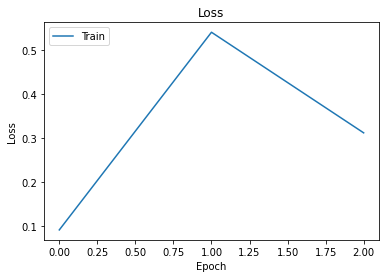

In [82]:
# Save model with best weights
checkpoint = ModelCheckpoint(model_path_ISOT, monitor='val_acc', verbose=1,  save_weights_only = True, mode='max')

# Train the model
print("------------------------------------")
print("Training model...")
history = lstm.fit(x, y, epochs = 3 , callbacks=[checkpoint], shuffle = False, validation_split = 0.1)

# Plot history for accuracy
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot history for loss
plt.plot(history.history['loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Save LSTM model

In [ ]:
#lstm.save(model_path)
#model = load_model(model_path)
#Load weights
#lstm.load_weights(model_path)

In [88]:
#get metrics against test set
test_sequences = tokenizer_isot.texts_to_sequences(test_data)
test_sequences = pad_sequences(test_sequences, maxlen = x_isot.shape[1])
lstm_preds = lstm.predict(test_sequences)
lstm_preds = np.where(lstm_preds > 0.5, 1, 0)
print_metrics('LSTM', test_labels, lstm_preds)

LSTM metrics:  accuracy:  0.8218421052631579 precision:  0.8774456277017291 recall:  0.8006441116893648 f1 score:  0.8062182358085892


In [91]:
def lstm_generalisation(lstm, test_data, tokenizer, x):
  general_test = tokenizer.texts_to_sequences(test_data['clean_words'])
  general_test = pad_sequences(general_test, maxlen = x.shape[1])
  lstm_general_preds = lstm.predict(general_test)
  lstm_general_preds = np.where(lstm_general_preds > 0.5, 1, 0)
  print_metrics('LSTM', test_data['label'], lstm_general_preds)

In [92]:
lstm_generalisation(lstm, cc_df, tokenizer_isot, x_isot)
#lstm_generalisation(dfs, lstm, tokenizer_isot, x_cc)

LSTM metrics:  accuracy:  0.6676609001126798 precision:  0.6811940469387434 recall:  0.6643324503571248 f1 score:  0.6584696642510846




# DistilBERT transformer

In [ ]:
#load pretrained DistilBERT
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

In [97]:
def process_transformer(training_data, model, tokenizer):
  x,y = transformer_preprocessing(training_data['clean_words'], training_data['label'])
  train, val, test = transformer_train_val_test(model, tokenizer, x, y)

  train.labels = [int(i) for i in train.labels]
  val.labels = [int(i) for i in val.labels]
  test.labels = [int(i) for i in test.labels]

  return train,val,test

train_isot, val_isot, test_isot = process_transformer(isot_df, model, tokenizer)
train_cc, val_cc, test_cc = process_transformer(cc_df, model, tokenizer)

In [98]:
def train_transformer(train, test, val, model):
  training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation             
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    evaluation_strategy = 'steps',
    save_strategy = 'steps',
    load_best_model_at_end = True 
)

  trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train,        
    eval_dataset=val,           
    compute_metrics = compute_metrics
)

  trainer.train()   

  return trainer

In [ ]:
trainer = train_transformer(train_isot, test_isot, val_isot, model)

In [ ]:
#save trained model and tokenizer
#model.save_pretrained('/content/drive/MyDrive/Dissertation/DistilBert/cc/1_epochs')
#tokenizer.save_pretrained('/content/drive/MyDrive/Dissertation/DistilBert/cc/1_epochs')

#save training log with training and validation loss
#log = trainer.state.log_history
#pickle.dump(log, open('/content/drive/MyDrive/Dissertation/DistilBert/log.pkl))

In [ ]:
#evaluation against test set
trainer.evaluate(test)

# BERT

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
#load pretrained BERT transformer
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
#generate fakenewsdataset objects for training on BERT
train_isot, val_isot, test_isot = process_transformer(isot_df, model, tokenizer)
train_cc, val_cc, test_cc = process_transformer(cc_df, model, tokenizer)

In [ ]:
trainer_bert = train_transformer(train,val,test, model)

In [ ]:
#save finetuned BERT model
#tokenizer.save_pretrained('/content/drive/MyDrive/Dissertation/Bert/ISOT/1_epoch/')
#model.save_pretrained('/content/drive/MyDrive/Dissertation/Bert/ISOT/1_epoch/')

#save training log
#bert_log = trainer_bert.state.log_history
#pkl.dump(bert_log, open('/content/drive/MyDrive/Dissertation/Bert/ISOT/1_epoch_log', 'wb'))

tokenizer config file saved in /content/drive/MyDrive/Dissertation/Bert/ISOT/1_epoch/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Dissertation/Bert/ISOT/1_epoch/special_tokens_map.json
Configuration saved in /content/drive/MyDrive/Dissertation/Bert/ISOT/1_epoch/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/Bert/ISOT/1_epoch/pytorch_model.bin


In [ ]:
#evaluate BERT against test set
trainer_bert.evaluate(test)

# DeBerta

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
#load pretrained deberta model from huggingface
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base-mnli")
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-base-mnli")

In [ ]:
#generate fakenewsdataset objects for training on BERT
train_isot, val_isot, test_isot = process_transformer(all_news1, model, tokenizer)
train_cc, val_cc, test_cc = process_transformer(dfs, model, tokenizer)

In [ ]:
trainer_deberta = transformer_train(train,val,test,model)

In [ ]:
#model.save_pretrained('/content/drive/MyDrive/Dissertation/deBERTa/cc/1_epoch')
#tokenizer.save_pretrained('/content/drive/MyDrive/Dissertation/deBERTa/cc/1_epoch')

#save training log
#deberta_log = trainer_deberta.state.log_history
#pkl.dump(deberta_log, open('/content/drive/MyDrive/Dissertation/Bert/ISOT/1_epoch_log', 'wb'))

Configuration saved in /content/drive/MyDrive/Dissertation/deBERTa/cc/1_epoch/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/deBERTa/cc/1_epoch/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/Dissertation/deBERTa/cc/1_epoch/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Dissertation/deBERTa/cc/1_epoch/special_tokens_map.json


('/content/drive/MyDrive/Dissertation/deBERTa/cc/1_epoch/tokenizer_config.json',
 '/content/drive/MyDrive/Dissertation/deBERTa/cc/1_epoch/special_tokens_map.json',
 '/content/drive/MyDrive/Dissertation/deBERTa/cc/1_epoch/vocab.json',
 '/content/drive/MyDrive/Dissertation/deBERTa/cc/1_epoch/merges.txt',
 '/content/drive/MyDrive/Dissertation/deBERTa/cc/1_epoch/added_tokens.json',
 '/content/drive/MyDrive/Dissertation/deBERTa/cc/1_epoch/tokenizer.json')

# Generalisation

In [ ]:
#dictionary containing locations of trained models
models_dict= {
    'deBERTa_CC' : '/content/drive/MyDrive/Dissertation/deBERTa/cc/1_epoch',
    'BERT_CC' : '/content/drive/MyDrive/Dissertation/Bert/cc/1_epochs',
    'DistilBERT_CC' : '/content/drive/MyDrive/Dissertation/DistilBert/cc/1_epochs',
    'deBERTa_ISOT' : '/content/drive/MyDrive/Dissertation/deBERTa/ISOT/1_epoch',
    'BERT_ISOT' : '/content/drive/MyDrive/Dissertation/Bert/ISOT/1_epoch',
    'DistilBERT_ISOT' : '/content/drive/MyDrive/Dissertation/DistilBert/big_dataset/1_epochs',
    'step_1_deBERTa_CC' : '/content/drive/MyDrive/Dissertation/deBERTa/Step_1/cc/1_epoch',
    'step_1_deBERTa_ISOT' : '/content/drive/MyDrive/Dissertation/deBERTa/ISOT/step_1',
    'step_1_BERT_CC' : '/content/drive/MyDrive/Dissertation/Bert/cc/step_1' ,
    'step_1_BERT_ISOT' : '/content/drive/MyDrive/Dissertation/Bert/ISOT/step_1' ,
    'step_1_DistilBERT_ISOT' : '/content/drive/MyDrive/Dissertation/DistilBert/ISOT/step_1',
    'step_1_DistilBERT_CC' : '/content/drive/MyDrive/Dissertation/DistilBert/cc/step_1',
}

In [ ]:
from sklearn.metrics import classification_report

#def evaluation function with macro average and classification report for each class
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    target_names = ['class 0', 'class 1']
    print(classification_report(labels, predictions, target_names=target_names))
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average= 'macro')
    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy_score(labels, predictions)
    }

In [ ]:
def generalisation_test(model, training_data, test_df, models_dict, step_1):
  if step_1 == True:
    model_name = 'step_1_' + model +  "_" + training_data
  else:
    model_name = model + "_" + training_data

  model_path = models_dict[model_name]
  model = AutoModelForSequenceClassification.from_pretrained(model_path)
  tokenizer = AutoTokenizer.from_pretrained(model_path)

  if test_df == 'ISOT':
    x,y = transformer_preprocessing(all_news1['hiya_words'], all_news1['label'])
  elif test_df == 'CC':
    x,y = transformer_preprocessing(dfs['Statement_clean'], dfs['label'])

  test_dataset = transformer(model, tokenizer, x, y)
  test_dataset.labels = [int(i) for i in test_dataset.labels]
  trainer = Trainer(model = model, compute_metrics = compute_metrics)
  preds = trainer.predict(test_dataset)
  return trainer.evaluate(test_dataset), preds

In [ ]:
#confusion matrix
mat = confusion_matrix(test_dataset.labels, preds.predictions.argmax(-1))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     mat.flatten()/np.sum(mat)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plot = sns.heatmap(mat, annot=labels, fmt='', cmap='Blues')

# Add step 1


In [ ]:
#load filtered training data
step_1_isot = pd.read_pickle('/content/drive/MyDrive/Dissertation/deBERTa/ISOT/step_1_df.pkl')
step_1_cc = pd.read_pickle('/content/drive/MyDrive/Dissertation/deBERTa/Step_1_df.pkl')

In [ ]:
#load pretrained fact vs. opinion classifier (generated in fact_opinion.ipynb)
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Dissertation/DistilBert/Step_1/50_epochs')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Dissertation/DistilBert/Step_1/50_epochs')

x,y = transformer_preprocessing(all_news1['clean_words'], all_news1['label'])
isot_data = transformer(model, tokenizer, x, y)
cc_data = transformer(model, tokenizer, x, y)

In [ ]:
trainer = Trainer(model = model)
preds_isot = trainer.predict(isot_data)
preds_cc = trainer.predict(cc_data)

In [ ]:
dfs['fact_opinion'] = preds_cc.predictions.argmax(-1)
step_1_cc = dfs[dfs['fact_opinion'] == 0]

all_news1['fact_opinion'] = preds_isot.predictions.argmax(-1)
step_1_isot = all_news1[all_news1['fact_opinion'] == 0]

In [15]:
def opinion_filtering(model_path, tokenizer_path, dataset):
  model = AutoModelForSequenceClassification.from_pretrained(model_path)
  tokenizer = AutoTokenizer.from_pretrained(model_path)

  x,y = transformer_preprocessing(dataset['clean_words'], dataset['label'])
  all_data = transformer(model, tokenizer, x, y)

  trainer = Trainer(model = model)
  preds = trainer.predict(all_data)
  preds = preds.predictions.argmax(-1)
  dataset['fact_opinion'] = preds
  step_1_df = dataset[dataset['fact_opinion'] == 0]

  return step_1_df


In [33]:
df = opinion_filtering(fact_opinion_model_filepath, fact_opinion_model_filepath, cc_df)

loading configuration file /content/drive/MyDrive/Dissertation/DistilBert/Step_1/50_epochs/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.9.2",
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/Dissertation/DistilBert/Step_1/50_epochs/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification